In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data yang digunakan

Data yang digunakan yaitu data buah-buahan yang dapat diakses di https://www.kaggle.com/datasets/moltean/fruits. Dataset ini terdiri dari 131 kelas yang memiliki total 90.483 gambar. Data tersebut dibagi menjadi 67.692 data pelatihan dan 22.688 data testing. Setiap gambar memiliki ukuran 100x100 piksel.

In [13]:
!unzip fruits.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini

Lakukan unzip pada file dataset yang sebelumnya sudah disiapkan. Data yang sudah diekstrak akan tersimpan di folder **fruits** dan siap untuk digunakan

# Library yang dibutuhkan

Library yang dibutuhkan sebagian besar merupakan library dari tensorflow yang digunakan untuk pemrosesan citra dan pemodelan.

In [14]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools
import warnings
warnings.filterwarnings("ignore")

# Konfigurasi

Buat variabel-variabel yang akan digunakan dalam pelatihan supaya mudah dicari dan diubah jika diperlukan. Variabel yang dibutuhkan yaitu ukuran gambar, jumlah epoch, ukuran batch setiap epoch dan jalur folder.

In [15]:
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

epochs = 16
batch_size = 128

In [22]:
train_path = 'fruits/fruits-360_dataset/fruits-360/Training'
valid_path = 'fruits/fruits-360_dataset/fruits-360/Test'

In [26]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [27]:
folders = glob(train_path + '/*')

# Menguji data

Untuk menguji apakah konfigurasi benar dan library terimpor dengan baik, coba menampilkan sebuah gambar secara acak.

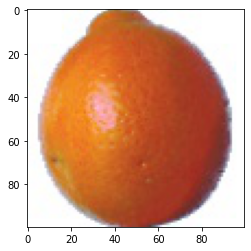

In [30]:
plt.imshow(image.load_img(np.random.choice(image_files)));

# ResNet
## Inisiasi

Inisiasikan model ResNet yang akan digunakan. Objek ResNet disimpan dalam variabel **res**. Disini menggunakan arsitektur imagenet.

In [32]:
# resnet base
res = ResNet50(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


## Mencegah model melakukan training ulang

Karena ResNet merupakan model yang sudah jadi, kita perlu melakukan **freeze** supaya tidak dilakukan pelatihan ulang.

In [33]:
for layer in res.layers:
  layer.trainable = False

## Menambah layer

Tambahkan layer yang dibutuhkan. Disini menambahkan

In [34]:
x = Flatten()(res.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# Membuat Model

## Membuat Objek Model

Buatlah sebuah objek model yang akan digunakan. Disini model memiliki input yaitu data dari model ResNet yang sebelumnya sudah dibuat serta output yang dihasilkan yaitu prediksi.

In [35]:
model = Model(inputs=res.input, outputs=prediction)

## Melihat ringkasan model

Setelah "mencampur" ResNet dengan model yang kita buat, berikut merupakan ringkasan model yang sudah dibuat sampai saat ini.

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

## Kompilasi model

Pilihan untuk parameter loss dan optimizer saat menyusun model ada banyak tetapi disini menggunakan **categorical_crossentropy** karena data yang kita latih akan mengeluarkan output banyak class, dan kita mencoba menggunakan '**adam**' sebagai optimizernya.

In [37]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

## Membuat Generator

Terdapat argumen seperti **horizontal_flip**, **vertical_flip**, dan **height_shift_range** adalah parameter dari ImageDataGenerator() untuk memvariasikan gambar. Contohnya seperti horizontal_flip digunakan untuk membalik gambar secara horizontal.

Argumen **validation_split** digunakan untuk melakukan validasi dari pelatihan, **validation_split** ini membagi data dari dataset sesuai yang diinginkan, pada kode diatas terdapat value **0.2** yang artinya dataset akan dibagi menjadi 80% untuk pelatihan, dan 20% untuk validasi.

In [38]:
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

## Membuat test generator

Test generator digunakan untuk membuat kelas gambar yang akan digunakan. Hasilnya, mendapatkan 131 kelas dengan 22.688 data

In [39]:
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 22688 images belonging to 131 classes.
{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3': 48, 'Grape Wh

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -122.68 max: 151.061


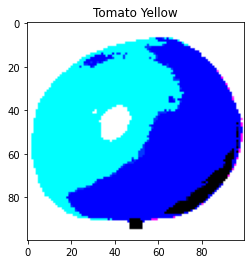

In [40]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

## Fungsi training dan validasi

Disini kita membagi dataset menjadi 2 yaitu, **train_generator** untuk pelatihan dan **valid_generator** untuk validasi.

**target_size** mengikuti variabel **IMAGE_SIZE** yang sebelumnya sudah dibuah.

**class_mode** menggunakan ‘**sparse**’ .

In [41]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# Pelatihan Model

Pelatihan dilakukan untuk mengenalkan data yang sudah disiapkan kepada model.
Dengan menggunakan **model.fit()** maka Keras akan melakukan training data, kita perlu memberikan **training_generator** sebagai data yang akan dilatih, **valid_generator** sebagai data untuk validasi, dan parameter epochs yaitu jumlah pembelajaran yang akan dilakukan. Disini menggunakan 16

In [42]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/16
528/528 [==============================] - 244s 435ms/step - loss: 0.7275 - accuracy: 0.9150 - val_loss: 0.8922 - val_accuracy: 0.9371
Epoch 2/16
528/528 [==============================] - 214s 406ms/step - loss: 0.2892 - accuracy: 0.9718 - val_loss: 0.8015 - val_accuracy: 0.9487
Epoch 3/16
528/528 [==============================] - 214s 404ms/step - loss: 0.2262 - accuracy: 0.9812 - val_loss: 0.9158 - val_accuracy: 0.9537
Epoch 4/16
528/528 [==============================] - 211s 399ms/step - loss: 0.2021 - accuracy: 0.9847 - val_loss: 0.6083 - val_accuracy: 0.9716
Epoch 5/16
528/528 [==============================] - 210s 397ms/step - loss: 0.2207 - accuracy: 0.9859 - val_loss: 1.4124 - val_accuracy: 0.9590
Epoch 6/16
528/528 [==============================] - 211s 400ms/step - loss: 0.1860 - accuracy: 0.9889 - val_loss: 0.6416 - val_accuracy: 0.9800
Epoch 7/16
528/528 [==============================] - 210s 398ms/step - loss: 0.1690 - accuracy: 0.9904 - val_loss: 0.9012 -

# Analisa

Setelah selesai melakukan training, lakukan analisa pada hasil pelatihan. Disini menampilkan grafik loss dan akurasi.

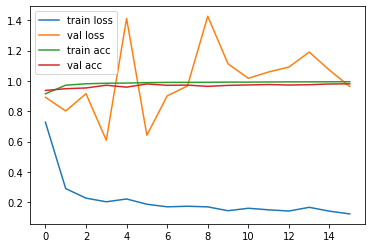

In [43]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

# Menyimpan model

Jika dirasa hasilnya sudah bagus dan sesuai harapan, simpan model ke dalam file.

In [50]:
model.save('model-resnet.h5')

# Pengujian

Untuk mengetahui apakah model yang kita sudah benar atau belum, coba untuk melakukan pengujian. Inputkan data apapun yang ada dalam class atau dalam model resNet dan lihat apakah prediksinya benar atau tidak

Saving 615ba2d388ba9.jpg to 615ba2d388ba9 (1).jpg
Prediksi:  Corn


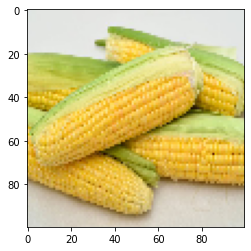

In [59]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(100, 100))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=batch_size)
  pr = np.argmax(classes, axis=1)
  
  # print("Probabilitas: ", classes)
  print("Prediksi: ", labels[pr[0]])